In [42]:
import tables
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from ctapipe.image import tailcuts_clean
from scipy.interpolate import griddata
from astropy import units as u
import numpy as np

In [44]:
data_path = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
#data_path = '/Users/nicolamarinello/Downloads/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data = tables.open_file(data_path)

# acquire the data
data_ainfo = data.root.Array_Info
data_einfo = data.root.Event_Info
data_LST = data.root.LST

print(repr(data_ainfo))
print(repr(data_einfo))
print(repr(data_LST))

# array info data
ai_run_array_direction = [x['run_array_direction']
                          for x in data_ainfo.iterrows()]
ai_tel_id = [x['tel_id'] for x in data_ainfo.iterrows()]
ai_tel_type = [x['tel_type'] for x in data_ainfo.iterrows()]
ai_tel_x = [x['tel_x'] for x in data_ainfo.iterrows()]
ai_tel_y = [x['tel_y'] for x in data_ainfo.iterrows()]
ai_tel_z = [x['tel_z'] for x in data_ainfo.iterrows()]

# event info data
ei_alt = [x['alt'] for x in data_einfo.iterrows()]
ei_az = [x['az'] for x in data_einfo.iterrows()]
ei_core_x = [x['core_x'] for x in data_einfo.iterrows()]
ei_core_y = [x['core_y'] for x in data_einfo.iterrows()]
ei_event_number = [x['event_number'] for x in data_einfo.iterrows()]
ei_h_first_int = [x['h_first_int'] for x in data_einfo.iterrows()]
ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
ei_particle_id = [x['particle_id'] for x in data_einfo.iterrows()]
ei_run_number = [x['run_number'] for x in data_einfo.iterrows()]
ei_LST_indices = [x['LST_indices'] for x in data_einfo.iterrows()]

# LST data
LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)
/Event_Info (Table(4853,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(sha

In [45]:
#e_idx = 58 , 674
e_idx = 2229
# select a spcific event
my_event = data_einfo[e_idx]
print('Event number: {}'.format(my_event['event_number']))
print('Energy: {} TeV'.format(my_event['mc_energy']))
print('Alt: {} rad'.format(my_event['alt']))
print('Az: {} rad'.format(my_event['az']))
my_indices = my_event['LST_indices']
print('LST_indices: ' + str(my_indices))

Event number: 375601
Energy: 0.9098318815231323 TeV
Alt: 1.2217304706573486 rad
Az: 6.283185005187988 rad
LST_indices: [2869 2870 2871 2872]


In [46]:
#we will take always the first lst index just for demostrations
# print event information
img_charge = LST_image_charge[my_indices[0]]
img_time = LST_image_peak_times[my_indices[0]]
print(img_charge)
print(img_time)

[-2.4409199  -0.7888425  -1.6547577  ... -1.2159475   2.3322046
 -0.56620854]
[16. 27.  0. ... 25. 26. 24.]


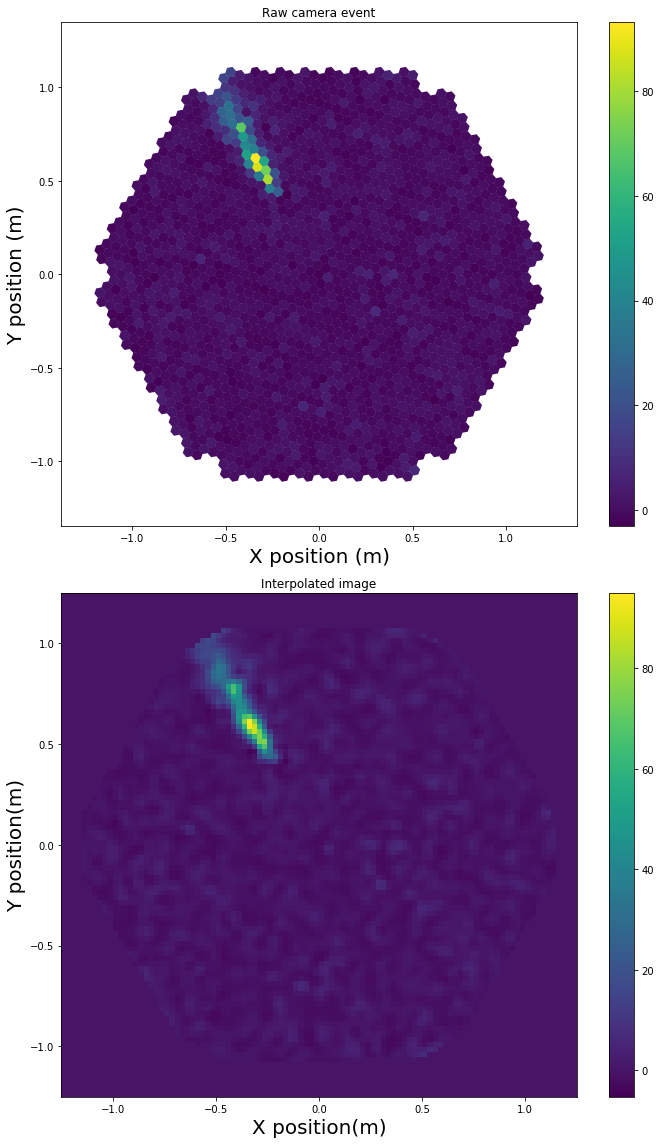

In [47]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

# plt.suptitle('EVENT')
disps = []

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)
clean = img_charge.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_charge
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)

grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(2, 1, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
#plt.savefig('real-interp.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

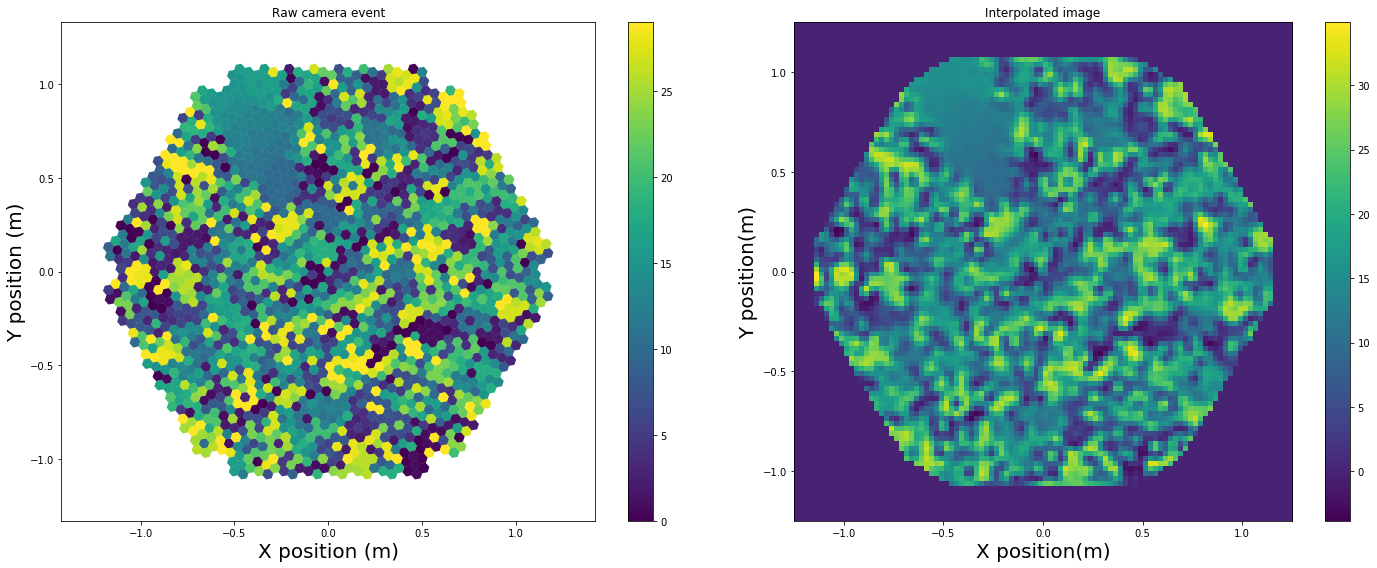

In [48]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

#plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_time, picture_thresh=10, boundary_thresh=5
)
clean = img_time.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_time
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)

#grid_x, grid_y = np.mgrid[-1.17:1.17:100j, -1.17:1.17:100j]
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="equal")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
plt.savefig('real-interp-time.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

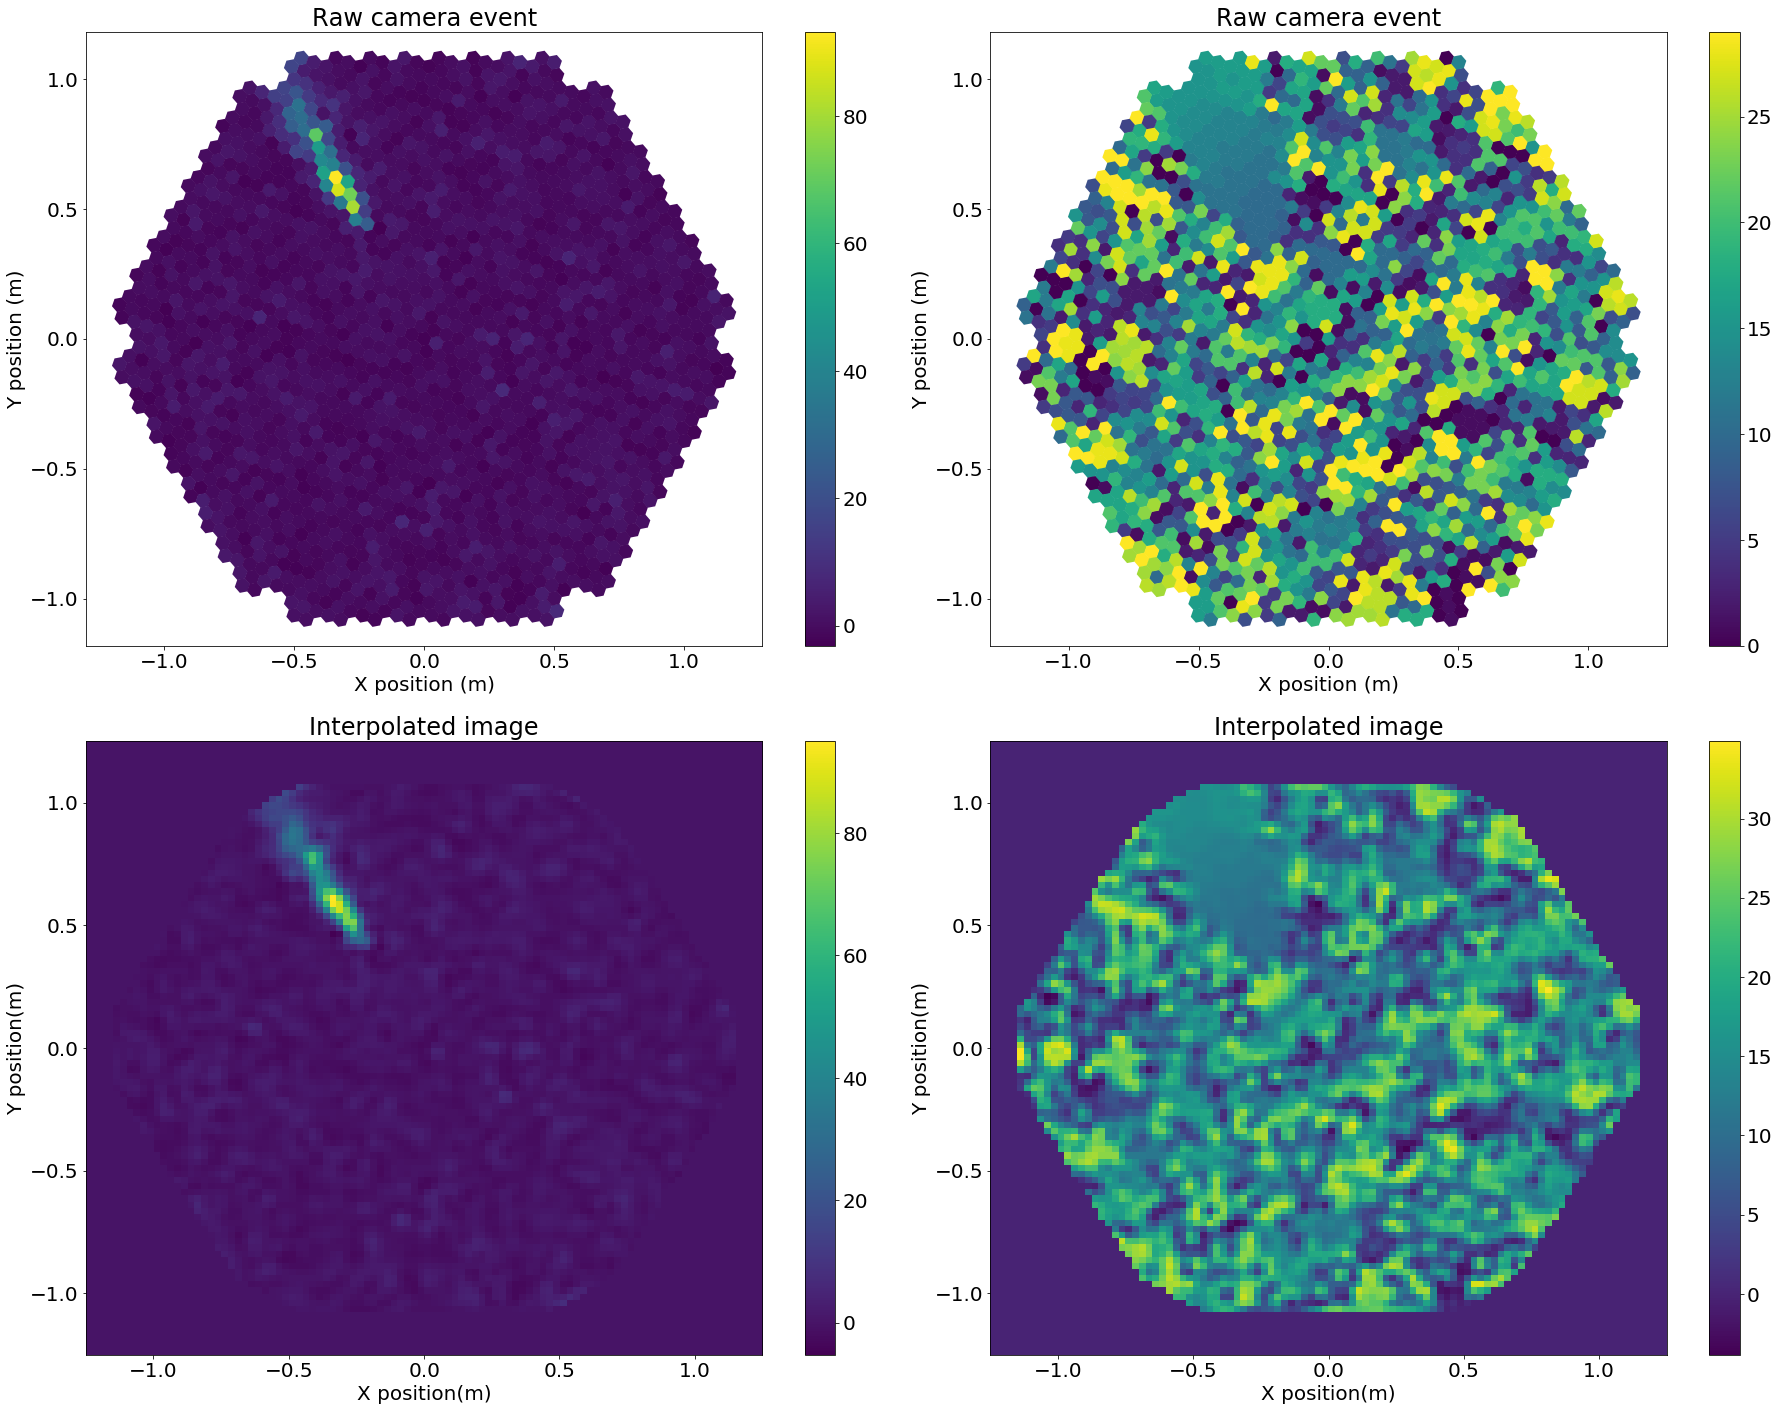

In [49]:
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_charge

ax = plt.subplot(2, 2, 3)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_time


ax = plt.subplot(2, 2, 4)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


plt.tight_layout()
plt.savefig('real-interp-4.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [50]:
print(100*100 - np.count_nonzero(grid_z))

3750


In [51]:
print(grid_z[99][:])
print(grid_z.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100, 100)


{'intensity': 1408.6658382415771,
 'kurtosis': 2.0663543519750247,
 'length': <Quantity 0.17381068 m>,
 'phi': <Angle 2.06827824 rad>,
 'psi': <Angle -1.09110863 rad>,
 'r': <Quantity 0.79771159 m>,
 'skewness': -0.28098394031337504,
 'width': <Quantity 0.04199072 m>,
 'x': <Quantity -0.38067929 m>,
 'y': <Quantity 0.70101859 m>}


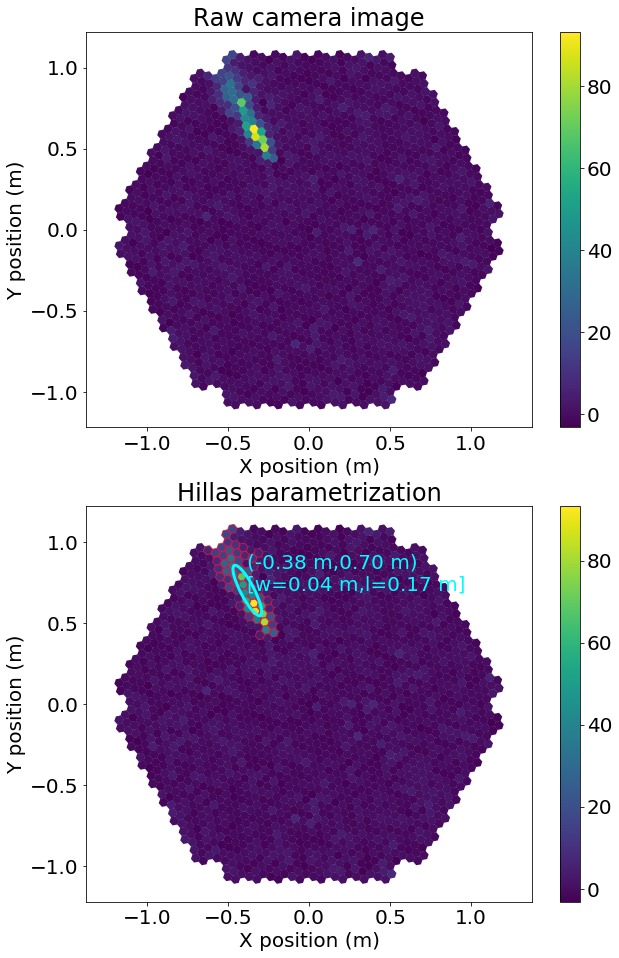

In [52]:
# hillas parameters

from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera image")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
# cleanmask = tailcuts_clean(
#    geom, img_charge, picture_thresh=10, boundary_thresh=5
#)

# Calculate image parameters
#hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
#disp.highlight_pixels(cleanmask, color='crimson')
#disp.overlay_moments(hillas, color='cyan', linewidth=3)

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

ax = plt.subplot(2, 1, 2)

disp = CameraDisplay(geom, ax=ax, title="Hillas parametrization")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)

# Calculate image parameters
hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
disp.highlight_pixels(cleanmask, color='crimson')
disp.overlay_moments(hillas, color='cyan', linewidth=3)

print(hillas)

# plt.show()

# plt.savefig('raw_hilas.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

2356
117
474
Energy: 1.5281083583831787 TeV
Energy: 93.2811050415039 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[32 33 34 35]
[198   0   0 199]


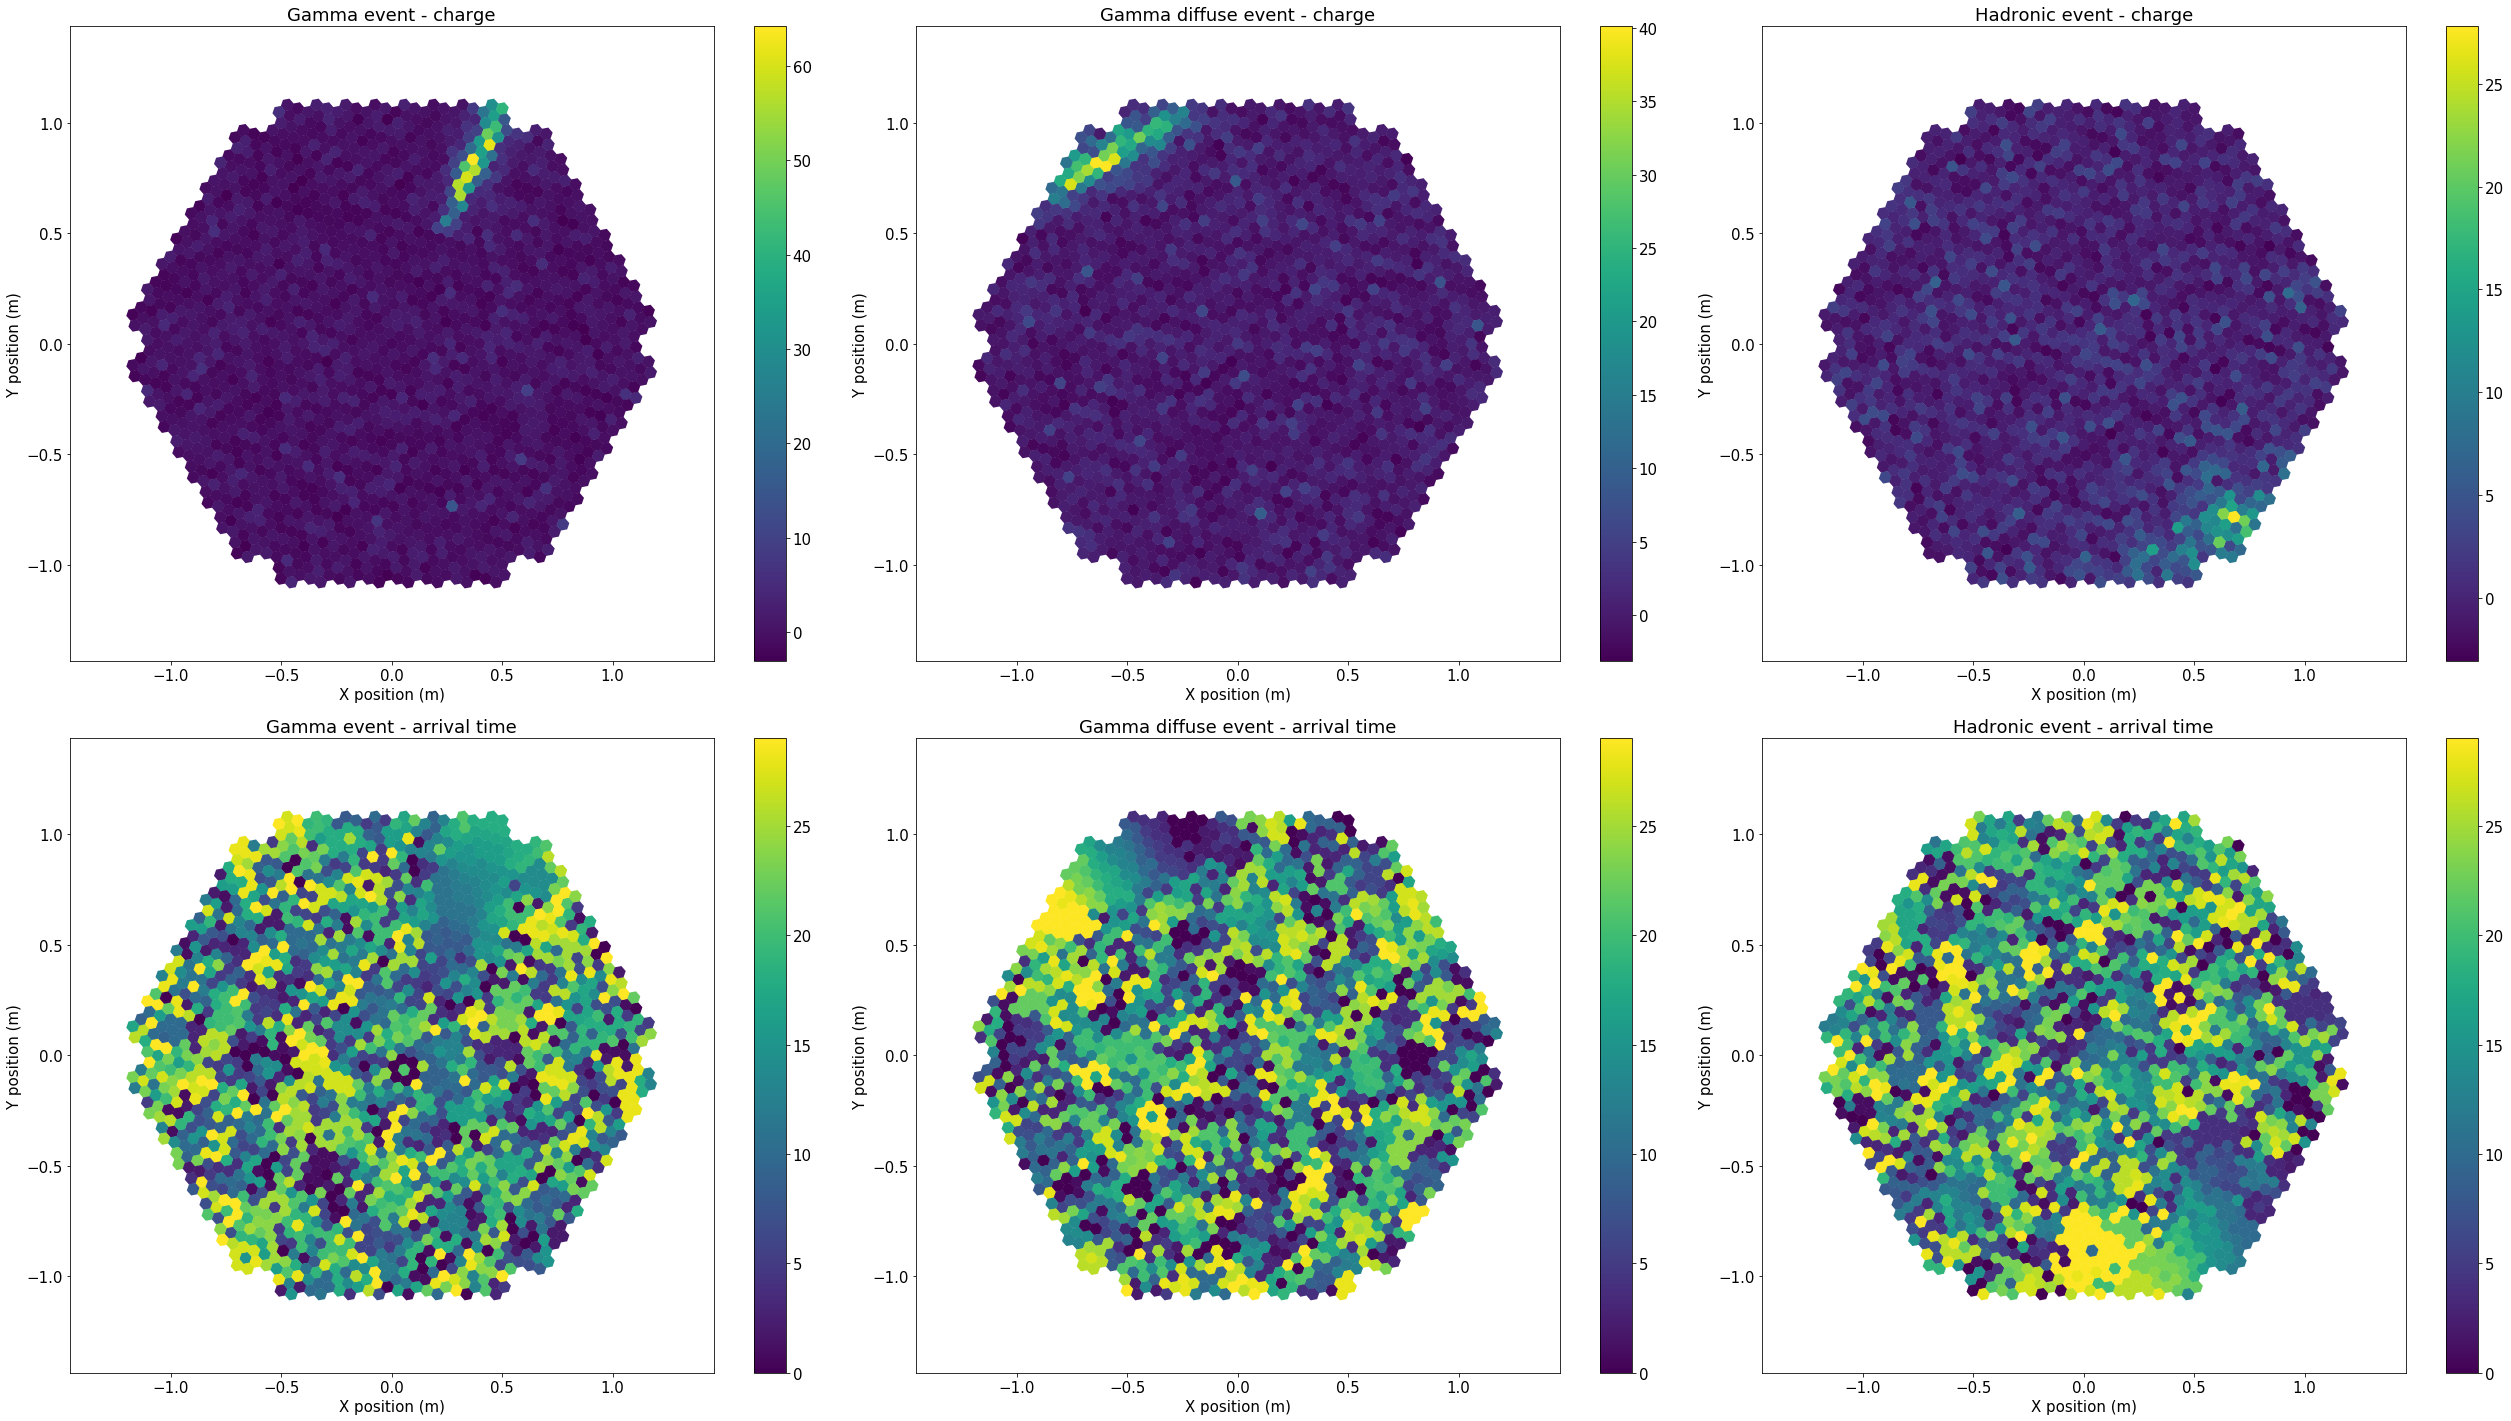

In [21]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import numpy as np
import matplotlib

data_path_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_gamdi = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun1000-5606___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5'
data_path_proto = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_gamdi = tables.open_file(data_path_gamdi)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_gamdi = data_gamdi.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_gamdi = data_gamdi.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_gamdi = [x['event_index'] for x in data_LST_gamdi.iterrows()]
LST_image_charge_gamdi = [x['image_charge'] for x in data_LST_gamdi.iterrows()]
LST_image_peak_times_gamdi = [x['image_peak_times'] for x in data_LST_gamdi.iterrows()]
ei_mc_energy_gamdi = [x['mc_energy'] for x in data_einfo_gamdi.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_gamdi = np.argsort(-np.array(ei_mc_energy_gamdi), axis=0)[10]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_gamdi)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_gamdi = data_einfo_gamdi[e_idx_gamdi]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_gamdi['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_gamdi = my_event_gamdi['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_gamdi)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_gamdi = LST_image_charge_gamdi[my_indices_gamdi[0]]
img_time_gamdi = LST_image_peak_times_gamdi[my_indices_gamdi[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
f = 2
fig = plt.figure(figsize=(36, 20))

ax = plt.subplot(2, 3, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 3, 2)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - charge")
disp.add_colorbar()
disp.image = img_charge_gamdi

ax = plt.subplot(2, 3, 3)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 3, 4)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 3, 5)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamdi

ax = plt.subplot(2, 3, 6)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

# matplotlib.rc('font', **font)

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

2356
474
Energy: 1.5281083583831787 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[198   0   0 199]


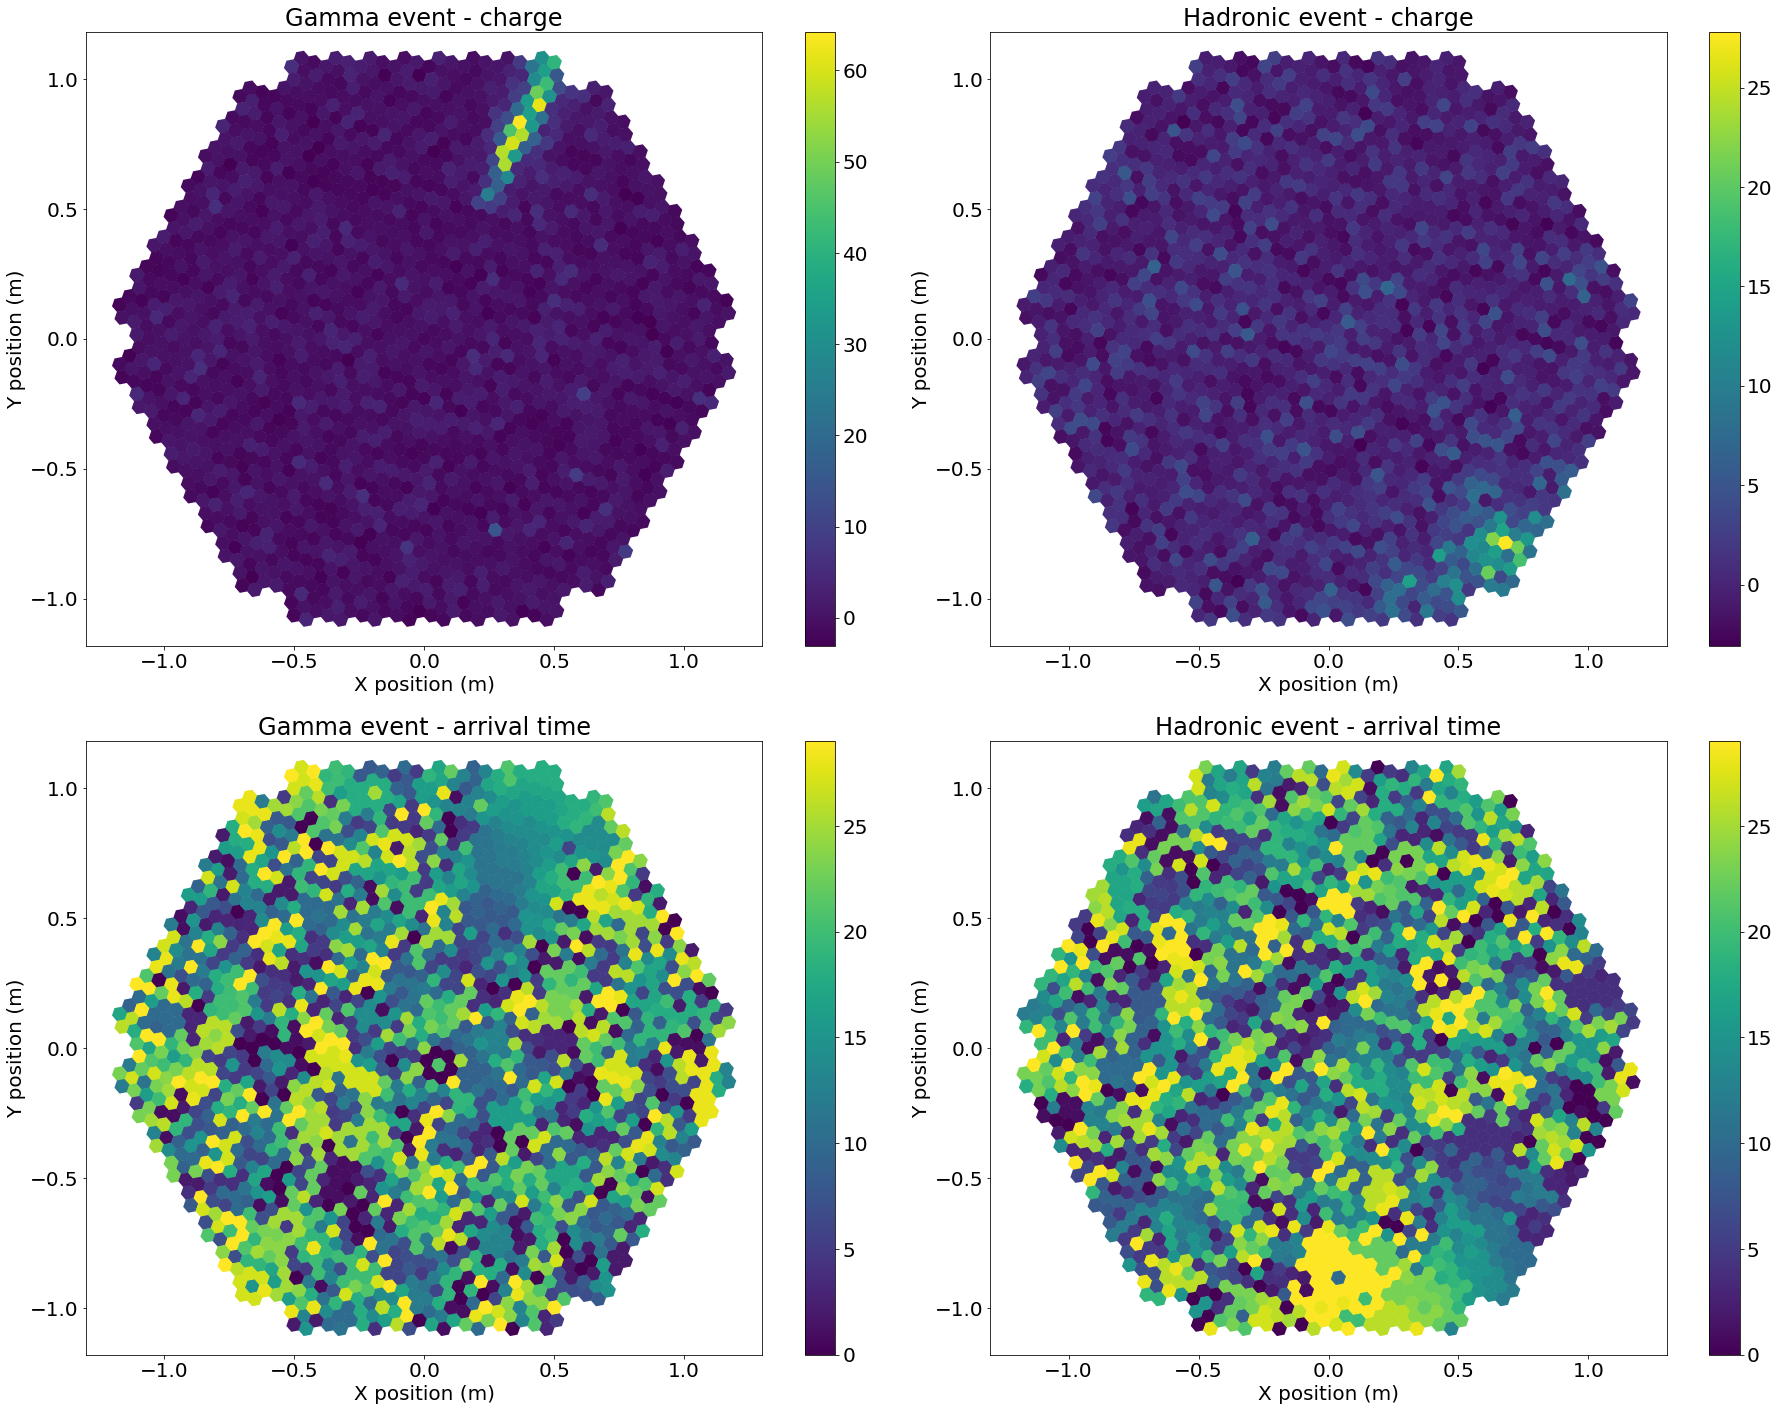

In [41]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import toymodel
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tables

data_path_gamma = '/Users/nicolamarinello/simulations/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_proto = '/Users/nicolamarinello/simulations/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135 or 553
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

'''
#overwrite with a toy model
# create a fake camera image to display:

model = toymodel.Gaussian(
    x=0.2 * u.m,
    y=0.0 * u.m,
    width=0.05 * u.m,
    length=0.15 * u.m,
    psi='35d',
)

img_charge_gamma, sig, bg = model.generate_image(geom, intensity=1500, nsb_level_pe=5)
'''

f = 2
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 2, 3)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 2, 4)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [24]:
# execute on VM with ipython
from keras.utils.data_utils import OrderedEnqueuer
from keras.utils.generic_utils import Progbar

from generators import DataGeneratorR
from utils import get_all_files
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib

def retrieve_energy(generator):
    # retrieve energy
    print('Retrieving ground truth...')
    gt_feature = []
    steps_done = 0
    steps = len(generator)

    enqueuer = OrderedEnqueuer(generator, use_multiprocessing=True)
    enqueuer.start(workers=24, max_queue_size=10)
    output_generator = enqueuer.get()

    progbar = Progbar(target=steps)

    while steps_done < steps:
        generator_output = next(output_generator)
        _, y = generator_output
        gt_feature.append(y)
        # print('steps_done', steps_done)
        # print(y)
        steps_done += 1
        progbar.update(steps_done)
        
    return np.array(gt_feature)
        

data_path_gamma = ['/ssdraptor/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/']
data_path_gamdi = ['/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/validation']
data_path_proto = ['/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/validation/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp_test/']

h5files_gamma = get_all_files(data_path_gamma)
h5files_gamdi = get_all_files(data_path_gamdi)
h5files_proto = get_all_files(data_path_proto)

print('Building test generator...')
generator_gamma = DataGeneratorR(h5files_gamma, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_gamdi = DataGeneratorR(h5files_gamdi, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_proto = DataGeneratorR(h5files_proto, feature='energy', batch_size=64, arrival_time=False, shuffle=False)

ei_mc_energy_gamma = retrieve_energy(generator_gamma)
ei_mc_energy_gamdi = retrieve_energy(generator_gamdi)
ei_mc_energy_proto = retrieve_energy(generator_proto)

ei_mc_energy_gamma = np.array(ei_mc_energy_gamma).reshape(64*len(generator_gamma))
ei_mc_energy_gamdi = np.array(ei_mc_energy_gamdi).reshape(64*len(generator_gamdi))
ei_mc_energy_proto = np.array(ei_mc_energy_proto).reshape(64*len(generator_proto))

f = 1.5
fig = plt.figure(figsize=(10*f, 7*f))

matplotlib.rcParams.update({'font.size': 13})

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)

bins = 50

ax = plt.subplot(gs[0, :2], )
#ax = plt.subplot(1, 3, 1)
plt.hist(ei_mc_energy_gamma, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Gamma energy distribution')

#ax = plt.subplot(1, 3, 2)
ax = plt.subplot(gs[0, 2:])
plt.hist(ei_mc_energy_gamdi, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Gamma-diffuse energy distribution')

#ax = plt.subplot(1, 3, 3)
ax = plt.subplot(gs[1, 1:3])
plt.hist(ei_mc_energy_proto, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Protons energy distribution')

#plt.suptitle('Dataset energy distribution')

plt.tight_layout()
plt.savefig('dataset_distrib.eps', format='eps', bbox_inches='tight', pad_inches=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/'

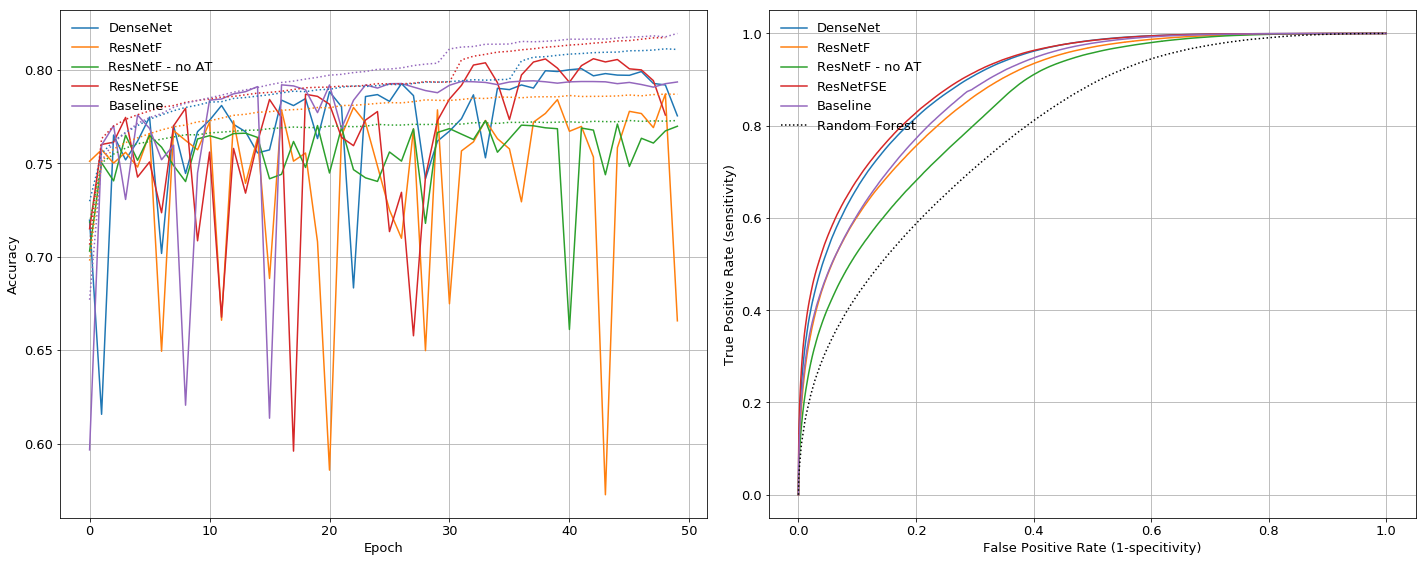

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

dnh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/train-history'
dnr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/DenseNet_42_0.80866_0.80057.h5_test.csv'

rnfh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/train-history'
rnfr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/ResNetF_49_0.78691_0.78701.h5_test.csv'

rnfnoath = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/train-history'
rnfnoatr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/ResNetF_34_0.77160_0.77273.h5_test.csv'

rnfseh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/train-history'
rnfser = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/ResNetFSE_43_0.81421_0.80588.h5_test.csv'

baselineh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/train-history'
baseliner = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/BaseLine_38_0.81494_0.79406.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
with open(dnh, 'rb') as f:
    densenet_history = pickle.load(f)
with open(rnfh, 'rb') as f:
    resnetf_history = pickle.load(f)
with open(rnfnoath, 'rb') as f:
    resnetfnoat_history = pickle.load(f)
with open(rnfseh, 'rb') as f:
    rnfse_history = pickle.load(f)
with open(baselineh, 'rb') as f:
    baseline_history = pickle.load(f)    

#compute ROCs
densenet_csv = pd.read_csv(dnr)
resnetf_csv = pd.read_csv(rnfr)
resnetfnoat_csv = pd.read_csv(rnfnoatr)
rnfse_csv = pd.read_csv(rnfser)
baseline_csv = pd.read_csv(baseliner)

rf_table = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_densenet, tpr_densenet, _ = roc_curve(densenet_csv['GroundTruth'], densenet_csv['Predicted'])
fpr_resnetf, tpr_resnetf, _ = roc_curve(resnetf_csv['GroundTruth'], resnetf_csv['Predicted'])
fpr_resnetfnoat, tpr_resnetfnoat, _ = roc_curve(resnetfnoat_csv['GroundTruth'], resnetfnoat_csv['Predicted'])
fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])


epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(densenet_history['val_accuracy'], label='DenseNet', color=cmap(0))
ax.plot(resnetf_history['val_accuracy'], label='ResNetF', color=cmap(1))
ax.plot(resnetfnoat_history['val_accuracy'], label='ResNetF - no AT', color=cmap(2))
ax.plot(rnfse_history['val_accuracy'][0:49], label='ResNetFSE', color=cmap(3))
ax.plot(baseline_history['val_accuracy'], label='Baseline', color=cmap(4))
ax.plot(densenet_history['accuracy'], ':', color=cmap(0))
ax.plot(resnetf_history['accuracy'], ':', color=cmap(1))
ax.plot(resnetfnoat_history['accuracy'], ':', color=cmap(2))
ax.plot(rnfse_history['accuracy'][0:49], ':', color=cmap(3))
ax.plot(baseline_history['accuracy'], ':', color=cmap(4))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

ax = axs[1]
ax.plot(fpr_densenet, tpr_densenet, label='DenseNet', color=cmap(0))
ax.plot(fpr_resnetf, tpr_resnetf, label='ResNetF', color=cmap(1))
ax.plot(fpr_resnetfnoat, tpr_resnetfnoat, label='ResNetF - no AT', color=cmap(2))
ax.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(3))
ax.plot(fpr_baseline, tpr_baseline, label='Baseline', color=cmap(4))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

plt.tight_layout()
plt.show()
fig.savefig('paper_class.eps', format='eps', transparent=False)

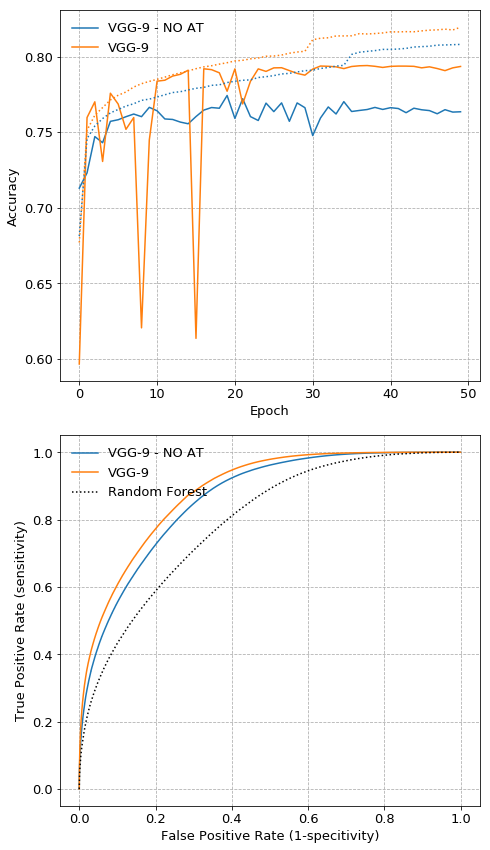

In [5]:

###############################################################################

###################### ARRIVAL TIME GAIN SEPARATION ###########################                

###############################################################################

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

baselineNOATh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-17_09-29/train-history'
baselineNOATr = '//Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-17_09-29/BaseLine_20_0.78280_0.77425.h5_test.csv'

baselineh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-14_10-33/train-history'
baseliner = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-14_10-33/BaseLine_38_0.81494_0.79406.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
#with open(baselineNOATh, 'rb') as f:
#    baselineNOAT_history = pickle.load(f)
#with open(baselineh, 'rb') as f:
#    baseline_history = pickle.load(f) 
    
baselineNOAT_history = pickle.load(open(baselineNOATh, 'rb'))
baseline_history = pickle.load(open(baselineh, 'rb'))

#compute ROCs
baselineNOAT_csv = pd.read_csv(baselineNOATr)
baseline_csv = pd.read_csv(baseliner)

rf_table = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_baselineNOAT, tpr_baselineNOAT, _ = roc_curve(baselineNOAT_csv['GroundTruth'], baselineNOAT_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])


epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(baselineNOAT_history['val_accuracy'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_accuracy'], label='VGG-9', color=cmap(1))
ax.plot(baselineNOAT_history['accuracy'], ':', color=cmap(0))
ax.plot(baseline_history['accuracy'], ':', color=cmap(1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

ax = axs[1]
ax.plot(fpr_baselineNOAT, tpr_baselineNOAT, label='VGG-9 - NO AT', color=cmap(0))
ax.plot(fpr_baseline, tpr_baseline, label='VGG-9', color=cmap(1))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('at_gain_baseline.eps', format='eps', transparent=False)

In [1]:
###############################################################################

############################## SEPARATION #####################################                

###############################################################################

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

baselineNOATh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/train-history'
baselineNOATr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/BaseLine_20_0.78306_0.77448.h5_test.csv'

baselineh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/train-history'
baseliner = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/BaseLine_29_0.80983_0.79393.h5_test.csv'

rnfh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/train-history'
rnfr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/ResNetF_38_0.80475_0.80049.h5_test.csv'

dnh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/train-history'
dnr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/DenseNet_46_0.81200_0.80139.h5_test.csv'

#rnfseh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/ResNetFSE_2019-05-11_11-04/train-history'
#rnfser = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/ResNetFSE_2019-05-11_11-04/ResNetFSE_43_0.81421_0.80588.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
baselineNOAT_history = pickle.load(open(baselineNOATh, 'rb'))
baseline_history = pickle.load(open(baselineh, 'rb'))
rnf_history = pickle.load(open(rnfh, 'rb'))
dn_history = pickle.load(open(dnh, 'rb'))
#rnfse_history = pickle.load(open(rnfseh, 'rb'))

#compute ROCs
baselineNOAT_csv = pd.read_csv(baselineNOATr)
baseline_csv = pd.read_csv(baseliner)
rnf_csv = pd.read_csv(rnfr)
dn_csv = pd.read_csv(dnr)
#rnfse_csv = pd.read_csv(rnfser)

rf_table = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_baselineNOAT, tpr_baselineNOAT, _ = roc_curve(baselineNOAT_csv['GroundTruth'], baselineNOAT_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rnf, tpr_rnf, _ = roc_curve(rnf_csv['GroundTruth'], rnf_csv['Predicted'])
fpr_dn, tpr_dn, _ = roc_curve(dn_csv['GroundTruth'], dn_csv['Predicted'])
#fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])

epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]

#ax.plot(baselineNOAT_history['val_accuracy'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_accuracy'], label='VGG-9', color=cmap(1))
ax.plot(rnf_history['val_accuracy'], label='ResNetF', color=cmap(2))
ax.plot(dn_history['val_accuracy'], label='DenseNet-BC (L=64, k=12)', color=cmap(2))
#ax.plot(rnfse_history['val_accuracy'], label='ResNetFSE', color=cmap(3))

#ax.plot(baselineNOAT_history['accuracy'], ':', color=cmap(0))
ax.plot(baseline_history['accuracy'], ':', color=cmap(1))
ax.plot(rnf_history['accuracy'], ':', color=cmap(2))
ax.plot(dn_history['accuracy'], ':', color=cmap(2))
#ax.plot(rnfse_history['accuracy'], ':', color=cmap(3))

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.plot(fpr_baselineNOAT, tpr_baselineNOAT, label='VGG-9 - NO AT', color=cmap(0))
ax.plot(fpr_baseline, tpr_baseline, label='VGG-9', color=cmap(1))
ax.plot(fpr_rnf, tpr_rnf, label='ResNetF', color=cmap(2))
ax.plot(fpr_dn, tpr_dn, label='DenseNet-BC (L=64, k=12)', color=cmap(2))
#ax.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(3))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='lower right', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('class_res.eps', format='eps', transparent=False)

UnpicklingError: pickle data was truncated

644890
645734


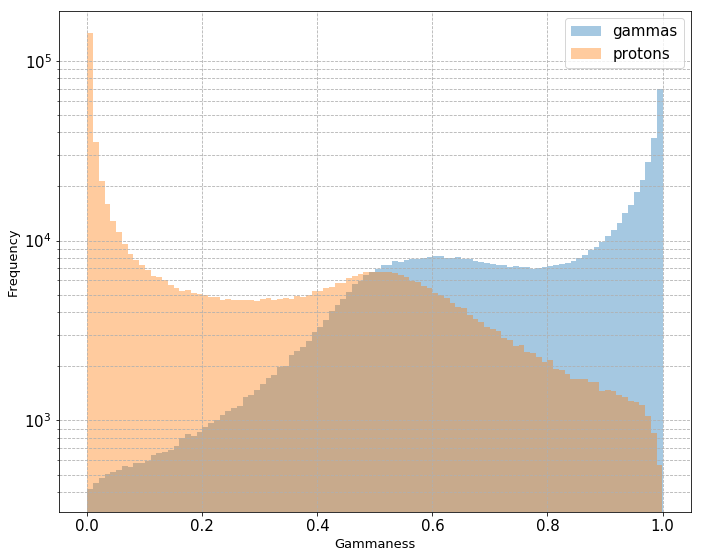

In [28]:
###############################################################################

####################### SEPARATION PROB DISTR BEST ############################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

rnf_csv_g = rnf_csv[rnf_csv['GroundTruth'] == 1]
rnf_csv_p = rnf_csv[rnf_csv['GroundTruth'] == 0]

g_count = rnf_csv_g.shape[0]
p_count = rnf_csv_p.shape[0]

print(g_count)
print(p_count)

fig = plt.figure(figsize=(10, 8))

plt.hist(rnf_csv_g['Predicted'], bins=100, density = False, label='gammas', alpha = 0.4)
plt.hist(rnf_csv_p['Predicted'], bins=100, density = False, label='protons', alpha = 0.4)
plt.yscale('log')
plt.xlabel('Gammaness', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(loc='upper right')
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

fig.tight_layout()
plt.show()
fig.savefig('separation_best_probdistr.pdf', format='pdf', transparent=False)

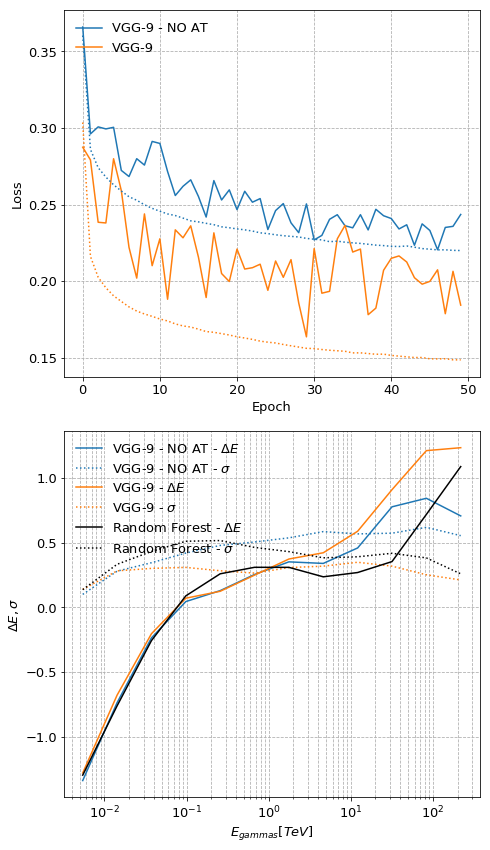

In [6]:
###############################################################################

###################### ARRIVAL TIME GAIN ENERGY RECO ##########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pickle

baselineeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/train-history'
baselineer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/BaseLine_30_0.15616_0.16365.h5_test.pkl'
baselineems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/mus_sigmas.npz'

baselineNOATeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/train-history'
baselineNOATer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/BaseLine_47_0.22042_0.22049.h5_test.pkl'
baselineNOATems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/mus_sigmas.npz'

#history
baseline_history = pickle.load(open(baselineeh, 'rb'))
baselineNOAT_history = pickle.load(open(baselineNOATeh, 'rb'))

# mus & sigma
baseline_ms = np.load(baselineems)
baselineNOAT_ms = np.load(baselineNOATems)

rfms = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['mus'], label='VGG-9 - NO AT - $\Delta E$', color=cmap(0))
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['sigmas'], ':', label='VGG-9 - NO AT - $\sigma$', color=cmap(0))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['mus'], label='VGG-9 - $\Delta E$', color=cmap(1))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['sigmas'], ':', label='VGG-9 - $\sigma$', color=cmap(1))
ax.semilogx(rf_ms['bin_centers'], rf_ms['mus'], color='black', label='Random Forest - $\Delta E$')
ax.semilogx(rf_ms['bin_centers'], rf_ms['sigmas'], ':', color='black', label='Random Forest - $\sigma$')
ax.set_xlabel('$E_{gammas}[TeV]$')
ax.set_ylabel(r'$\Delta E, \sigma$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_at_gain.eps', format='eps', transparent=False)

In [61]:
###############################################################################

######################################## ENERGY RECO ##########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pickle

baselineNOATeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/train-history'
baselineNOATer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/BaseLine_47_0.22042_0.22049.h5_test.pkl'
baselineNOATems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/mus_sigmas.npz'

baselineeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/train-history'
baselineer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/BaseLine_30_0.15616_0.16365.h5_test.pkl'
baselineems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/mus_sigmas.npz'

resnetheh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/train-history'
resnether = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/ResNetH_27_0.11675_0.13286.h5_test.pkl'
resnethems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/mus_sigmas.npz'

resnethseeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/train-history'
resnethseer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/ResNetHSE_50_0.12730_0.13117.h5_test.pkl'
resnethseems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/mus_sigmas.npz'

densenet169eh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/train-history'
densenet169er = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/DenseNet169_43_0.13453_0.16394.h5_test.pkl'
densenet169ems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/mus_sigmas.npz'

denseneteh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/train-history'
denseneter = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/DenseNet_50_0.13568_0.13484.h5_test.pkl'
densenetems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/mus_sigmas.npz'

#resnethseMAPEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria\ delle\ Telecomunicazioni/2\ Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/train-history'
resnethseMAPEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/ResNetHSE_10_124.73765_102.66618.h5_test.pkl'
resnethseMAPEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/mus_sigmas.npz'


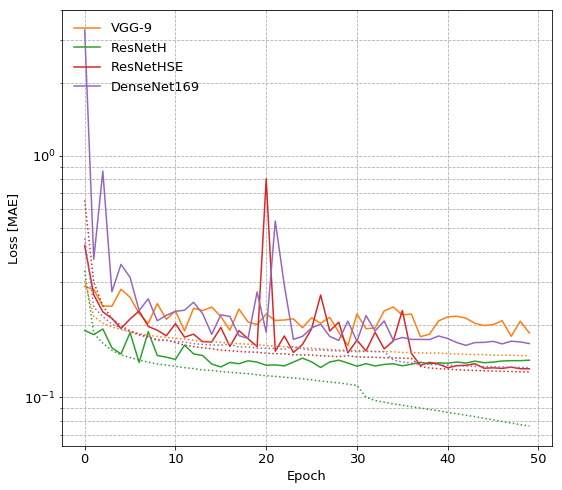

In [9]:
#################### LOSS ONLY ####################################

#history
baselineNOAT_history = pickle.load(open(baselineNOATeh, 'rb'))
baseline_history = pickle.load(open(baselineeh, 'rb'))
resneth_history = pickle.load(open(resnetheh, 'rb'))
resnethse_history = pickle.load(open(resnethseeh, 'rb'))
densenet169_history = pickle.load(open(densenet169eh, 'rb'))
densenet_history = pickle.load(open(denseneteh, 'rb'))

# mus & sigma
baselineNOAT_ms = np.load(baselineNOATems)
baseline_ms = np.load(baselineems)
resneth_ms = np.load(resnethems)
resnethse_ms = np.load(resnethseems)
densenet169_ms = np.load(densenet169ems)
densenet_ms = np.load(densenetems)

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs
#ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(2))
ax.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(3))
ax.plot(densenet169_history['val_losses'], label='DenseNet169', color=cmap(4))

#ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.plot(resneth_history['losses'], ':', color=cmap(2))
ax.plot(resnethse_history['losses'], ':', color=cmap(3))
ax.plot(densenet169_history['losses'], ':', color=cmap(4))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss [MAE]')
ax.set_yscale('log')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_history.eps', format='eps', transparent=False)

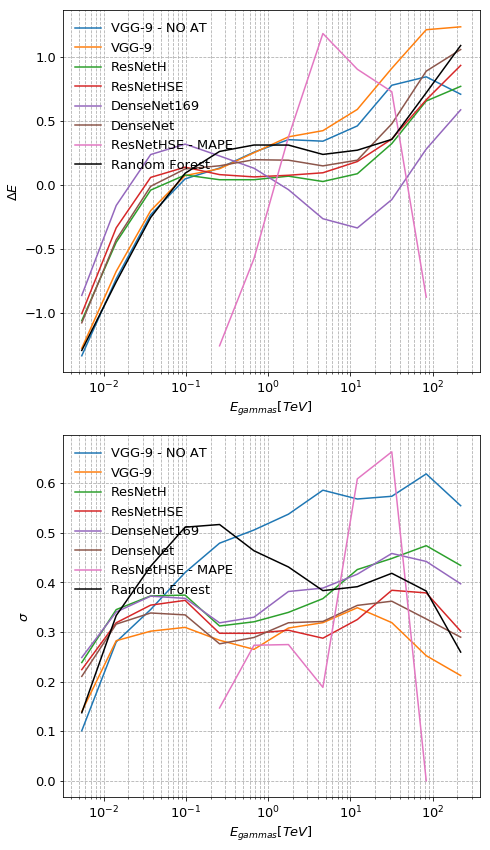

In [62]:
#################### BIAS AND RESOLUTION ####################################

# mus & sigma
baselineNOAT_ms = np.load(baselineNOATems)
baseline_ms = np.load(baselineems)
resneth_ms = np.load(resnethems)
resnethse_ms = np.load(resnethseems)
densenet169_ms = np.load(densenet169ems)
densenet_ms = np.load(densenetems)

resnethseMAPE_ms = np.load(resnethseMAPEems)

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['mus'], label='VGG-9 - NO AT', color=cmap(0))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['mus'], label='VGG-9', color=cmap(1))
ax.semilogx(resneth_ms['bin_centers'], resneth_ms['mus'], label='ResNetH', color=cmap(2))
ax.semilogx(resnethse_ms['bin_centers'], resnethse_ms['mus'], label='ResNetHSE', color=cmap(3))
ax.semilogx(densenet169_ms['bin_centers'], densenet169_ms['mus'], label='DenseNet169', color=cmap(4))
ax.semilogx(densenet_ms['bin_centers'], densenet_ms['mus'], label='DenseNet', color=cmap(5))

ax.semilogx(resnethseMAPE_ms['bin_centers'], resnethseMAPE_ms['mus'], label='ResNetHSE - MAPE', color=cmap(6))

ax.semilogx(rf_ms['bin_centers'], rf_ms['mus'], color='black', label='Random Forest')
ax.set_xlabel('$E_{gammas}[TeV]$')
ax.set_ylabel(r'$\Delta E$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['sigmas'], label='VGG-9 - NO AT', color=cmap(0))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['sigmas'], label='VGG-9', color=cmap(1))
ax.semilogx(resneth_ms['bin_centers'], resneth_ms['sigmas'], label='ResNetH', color=cmap(2))
ax.semilogx(resnethse_ms['bin_centers'], resnethse_ms['sigmas'], label='ResNetHSE', color=cmap(3))
ax.semilogx(densenet169_ms['bin_centers'], densenet169_ms['sigmas'], label='DenseNet169', color=cmap(4))
ax.semilogx(densenet_ms['bin_centers'], densenet_ms['sigmas'], label='DenseNet', color=cmap(5))

ax.semilogx(resnethseMAPE_ms['bin_centers'], resnethseMAPE_ms['sigmas'], label='ResNetHSE - MAPE', color=cmap(6))

ax.semilogx(rf_ms['bin_centers'], rf_ms['sigmas'], color='black', label='Random Forest')
ax.set_xlabel('$E_{gammas}[TeV]$')
ax.set_ylabel(r'$\sigma$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias_reso.eps', format='eps', transparent=False)

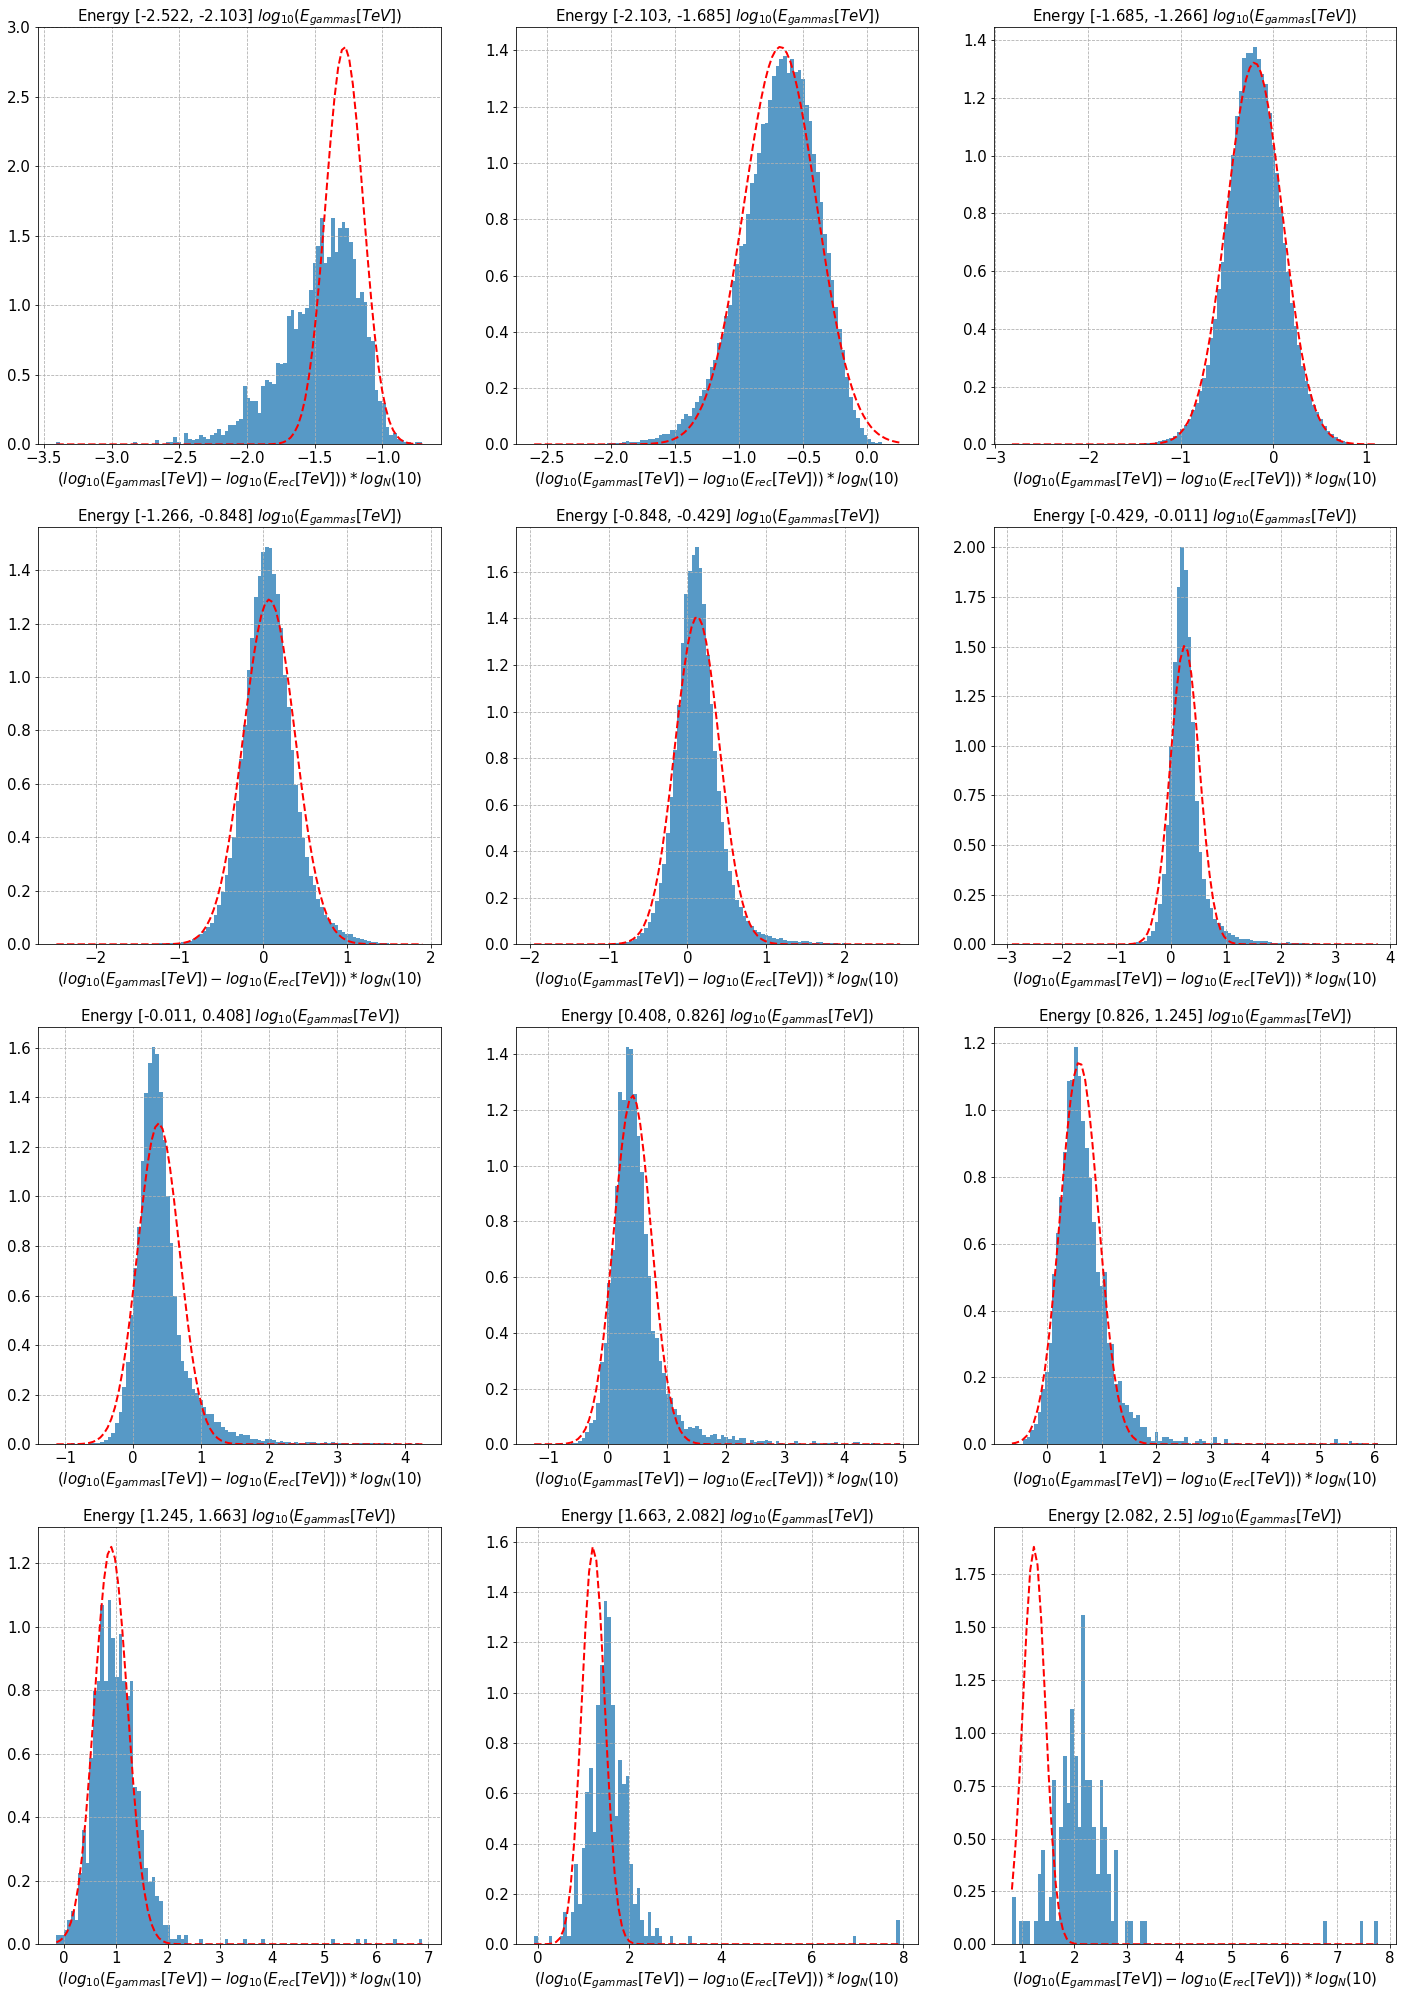

In [41]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAMS ###########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['GroundTruth']), max(df['GroundTruth']), n_figs + 1)
mus = np.array([])
sigmas = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['GroundTruth'] >= edge1) & (df['GroundTruth'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = ((dfbe['GroundTruth'] - dfbe['Predicted']) * np.log(10))
        section = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(section)
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        n, bins, patches = plt.hist(difE, 100, density=1, alpha=0.75)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--', linewidth=2)
        plt.xlabel('$(log_{10}(E_{gammas}[TeV])-log_{10}(E_{rec}[TeV]))*log_{N}(10)$', fontsize=15)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        plt.title('Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{gammas}[TeV])$',
                 fontsize=15)
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')

#fig.tight_layout(rect=[0, 0.03, 1, 0.85])
fig.tight_layout()
plt.show()
fig.savefig('energy_best_histogram.eps', format='eps', transparent=False)

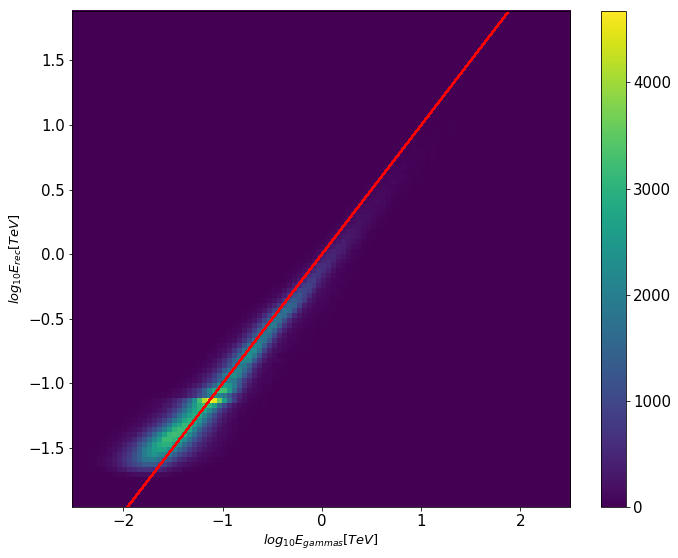

In [46]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAM 2D #########################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

fig = plt.figure(figsize=(10, 8))

hE = plt.hist2d(df['GroundTruth'], df['Predicted'], bins=100)
plt.colorbar(hE[3])
plt.xlabel('$log_{10}E_{gammas}[TeV]$', fontsize=13)
plt.ylabel('$log_{10}E_{rec}[TeV]$', fontsize=13)
plt.plot(df['GroundTruth'], df['GroundTruth'], "-", color='red')

#plt.title('Histogram2D - Energy reconstruction')
fig.tight_layout()
plt.show()
fig.savefig('energy_best_hist2d.eps', format='eps', transparent=False)

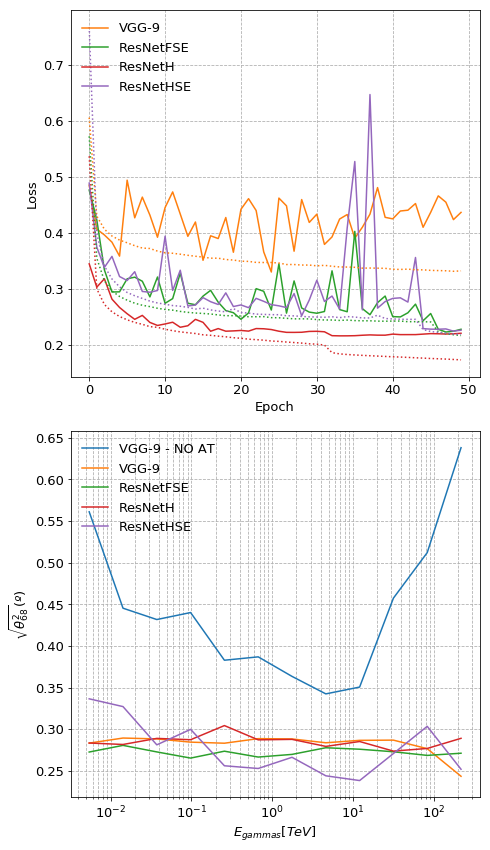

In [32]:
###############################################################################

####################### ARRIVAL TIME GAIN DIRE RECO ###########################                

###############################################################################

# direction reconstruction
import pickle

baselineNOATdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/train-history'
baselineNOATdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/ang_reso_plt.npz'
baselineNOATdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/BaseLine_49_0.50128_0.45132.h5_test.pkl'

baselinedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/train-history'
baselinedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/ang_reso_plt.npz'
baselinedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/BaseLine_25_0.34697_0.32997.h5_test.pkl'

resnetfsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/train-history'
resnetfsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ang_reso_plt.npz'
resnetfsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ResNetFSE_48_0.21978_0.22281.h5_test.pkl'

resnethdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/train-history'
resnethdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ang_reso_plt.npz'
resnethdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ResNetH_34_0.18375_0.21594.h5_test.pkl'

resnethsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/train-history'
resnethsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ang_reso_plt.npz'
resnethsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ResNetHSE_49_0.21935_0.22435.h5_test.pkl'

#history
baselineNOAT_history = pickle.load(open(baselineNOATdh, 'rb'))
baseline_history = pickle.load(open(baselinedh, 'rb'))
resnetfse_history = pickle.load(open(resnetfsedh, 'rb'))
resneth_history = pickle.load(open(resnethdh, 'rb'))
resnethse_history = pickle.load(open(resnethsedh, 'rb'))

# angulare reso
baselineNOAT_areso = np.load(baselineNOATdres)
baseline_areso = np.load(baselinedres)
resnetfse_areso = np.load(resnetfsedres)
resneth_areso = np.load(resnethdres)
resnethse_areso = np.load(resnethsedres)

rfareso = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/ang_reso_plt.npz'
rf_areso = np.load(rfareso)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
#ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(resnetfse_history['val_losses'], label='ResNetFSE', color=cmap(2))
ax.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(3))
ax.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(4))

#ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.plot(resnetfse_history['losses'], ':', color=cmap(2))
ax.plot(resneth_history['losses'], ':', color=cmap(3))
ax.plot(resnethse_history['losses'], ':', color=cmap(4))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
#ax.set_yscale('log')
ax.semilogx(baselineNOAT_areso['bin_centers'], baselineNOAT_areso['sqrttheta268'], label='VGG-9 - NO AT', color=cmap(0))
ax.semilogx(baseline_areso['bin_centers'], baseline_areso['sqrttheta268'], label='VGG-9', color=cmap(1))
ax.semilogx(resnetfse_areso['bin_centers'], resnetfse_areso['sqrttheta268'], label='ResNetFSE', color=cmap(2))
ax.semilogx(resneth_areso['bin_centers'], resneth_areso['sqrttheta268'], label='ResNetH', color=cmap(3))
ax.semilogx(resnethse_areso['bin_centers'], resnethse_areso['sqrttheta268'], label='ResNetHSE', color=cmap(4))

ax.set_xlabel('$E_{gammas}[TeV]$')
ax.set_ylabel(r'$\sqrt{\theta^2_{68}}(º)$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('dirreco_results.eps', format='eps', transparent=False)


Total:  2640
0.68 of total: 1804
Fraction: 0.6833333333333333

Total:  66658
0.68 of total: 47556
Fraction: 0.7134327462570134

Total:  196047
0.68 of total: 134195
Fraction: 0.6845042260274322

Total:  175434
0.68 of total: 128473
Fraction: 0.7323152866605105

Total:  113385
0.68 of total: 77776
Fraction: 0.685946112801517

Total:  55731
0.68 of total: 37992
Fraction: 0.6817031813532863

Total:  22766
0.68 of total: 15994
Fraction: 0.7025388737591145

Total:  7837
0.68 of total: 5340
Fraction: 0.6813831823401811

Total:  2896
0.68 of total: 1983
Fraction: 0.6847375690607734

Total:  947
0.68 of total: 650
Fraction: 0.6863780359028511

Total:  393
0.68 of total: 268
Fraction: 0.6819338422391857

Total:  129
0.68 of total: 89
Fraction: 0.689922480620155


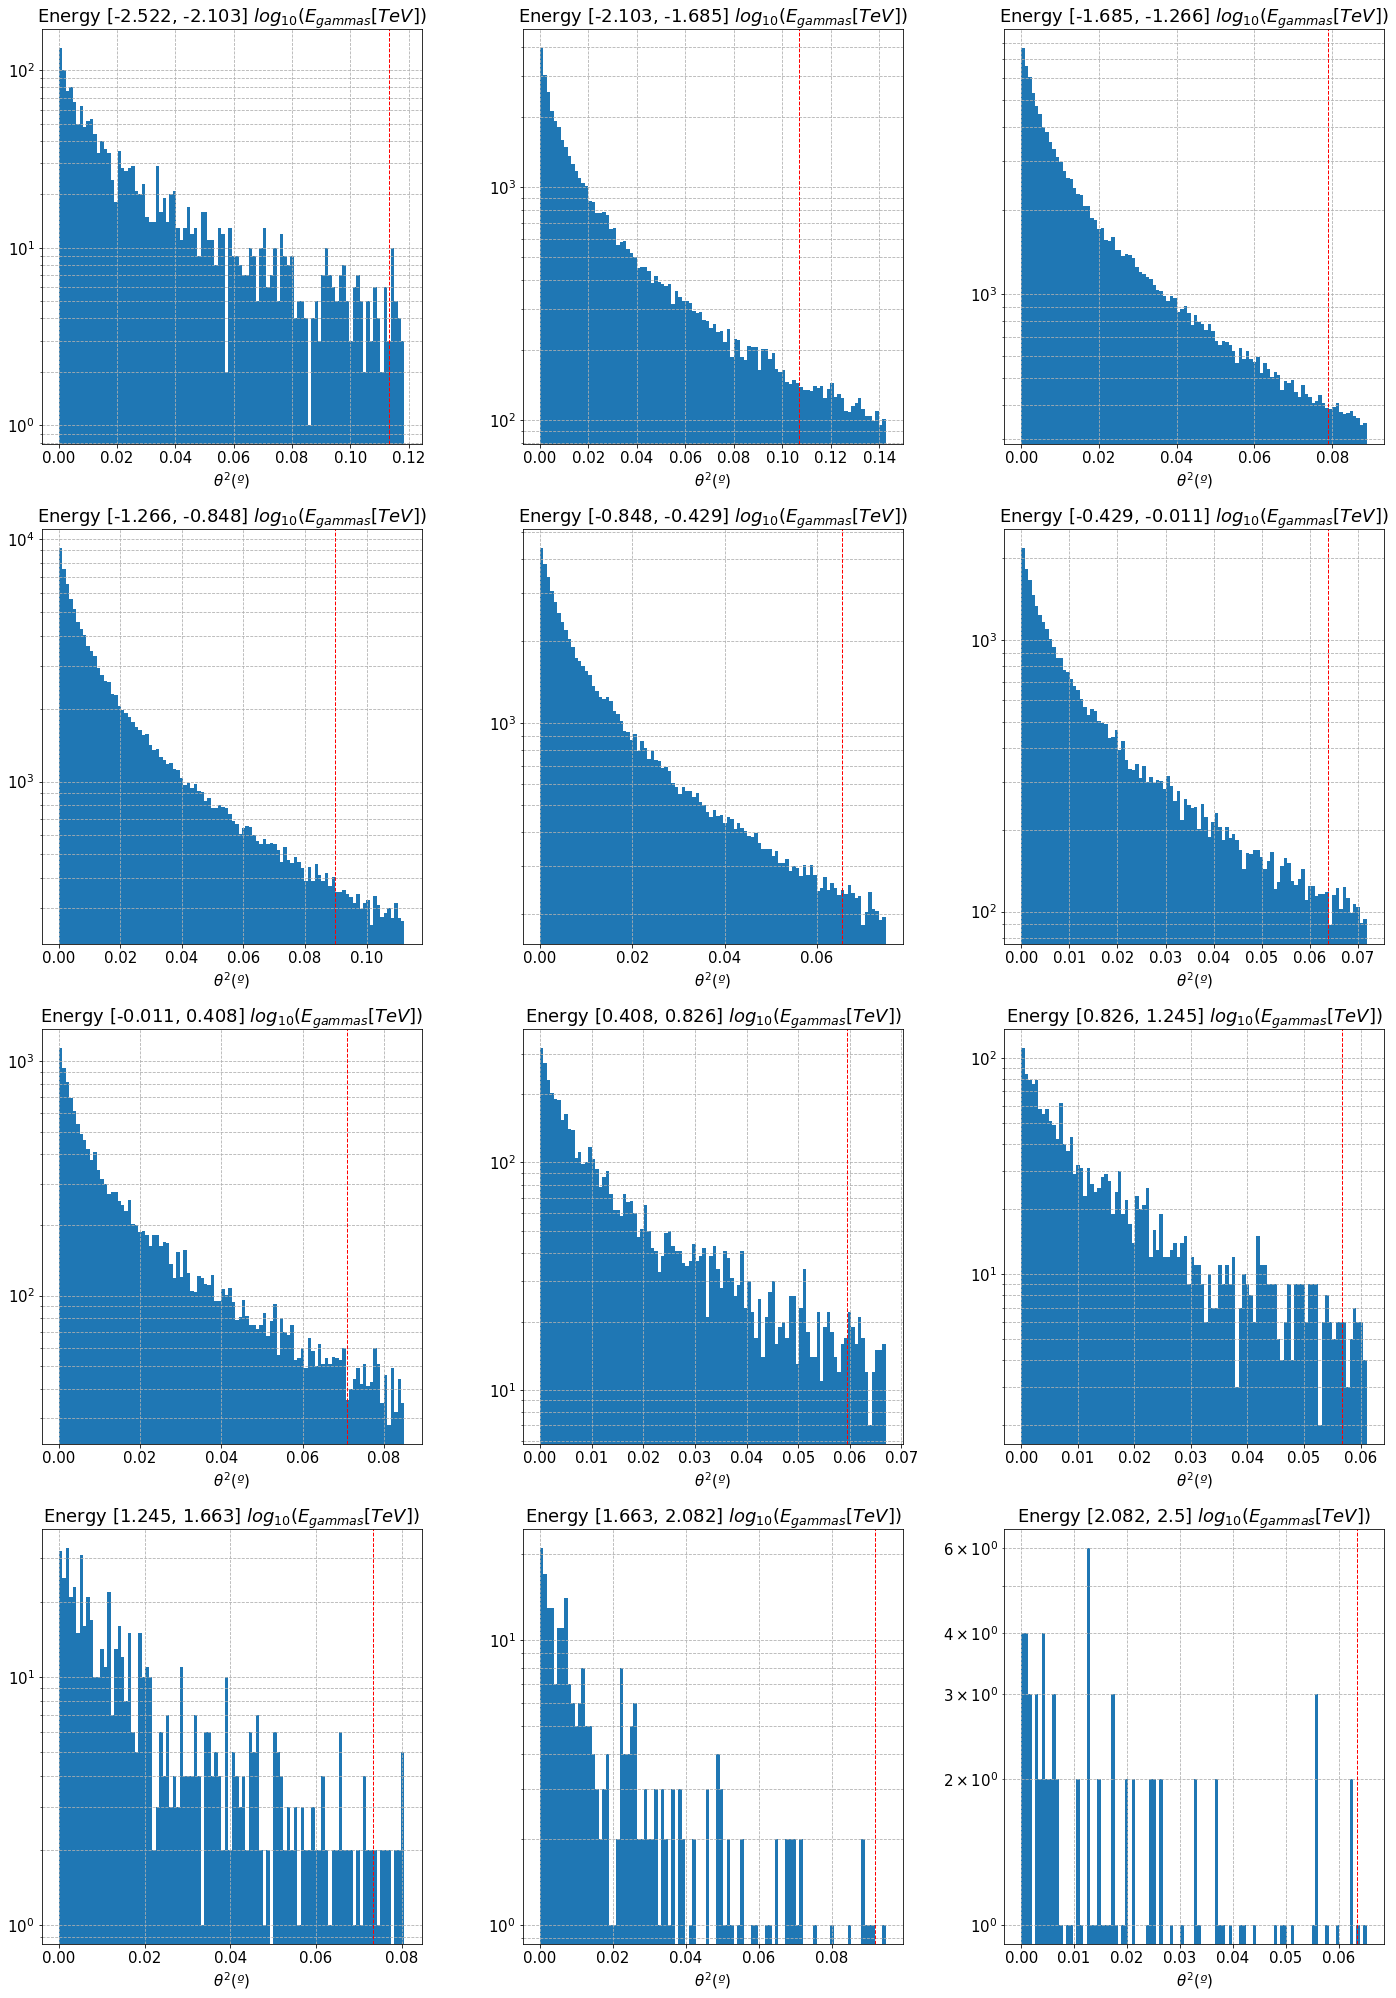

In [35]:
###############################################################################

###################### BEST MODEL DIRECTION HISTOGRAMS ########################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(resnethsedtest)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['energy']), max(df['energy']), n_figs + 1)
theta2_68 = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        dfbe = df[(df['energy'] >= edge1) & (df['energy'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        theta2 = (dfbe['src_x'] - dfbe['src_x_rec']) ** 2 + (dfbe['src_y'] - dfbe['src_y_rec']) ** 2
        total = len(theta2)
        # theta2_68 = np.append(theta2_68, np.percentile(theta2, 68))
        hist = np.histogram(theta2, bins=1000)
        for k in range(0, len(hist[0]) + 1):
            fraction = np.sum(hist[0][:k]) / total
            if fraction > 0.68:
                print('\nTotal: ', total)
                print('0.68 of total:', np.sum(hist[0][:k]))
                print('Fraction:', fraction)
                theta2_68 = np.append(theta2_68, hist[1][k])
                break
        n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k+1])) #hist[1][k+1] one bin more than 68% cont
        plt.axvline(hist[1][k], color='r', linestyle='dashed', linewidth=1)
        plt.yscale('log', nonposy='clip')
        plt.xlabel(r'$\theta^{2}(º)$', fontsize=15)
        plt.title(
            'Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{gammas}[TeV])$')
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')
        # + ' Mean: ' + str(round(mu, 3)) + ' Std: ' + str(round(sigma, 3)))

fig.tight_layout()
plt.show()
fig.savefig('best_direco_histograms.eps', format='eps', transparent=False)